In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

In [10]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=4, emb_size=128, img_size=32):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)
        num_patches = (img_size // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_size))
        self.pos_emb = nn.Parameter(torch.zeros(1, num_patches + 1, emb_size))

    def forward(self, x):
        B = x.size(0)
        x = self.proj(x)                    # (B, emb_size, H', W')
        x = x.flatten(2)                    # (B, emb_size, N)
        x = x.transpose(1, 2)               # (B, N, emb_size)
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_token, x], dim=1)  # (B, N+1, emb_size)
        x = x + self.pos_emb[:, :x.size(1), :]
        return x

In [11]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, emb_size=128, num_heads=4, dropout=0.1):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.head_dim = emb_size // num_heads
        self.qkv = nn.Linear(emb_size, 3 * emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x):
        B, N, _ = x.shape
        qkv = self.qkv(x)                          # (B, N, 3*emb_size)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)           # (3, B, num_heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        att = torch.softmax(scores, dim=-1)
        att = self.att_drop(att)
        out = torch.matmul(att, v)                # (B, num_heads, N, head_dim)
        out = out.transpose(1, 2).flatten(2)      # (B, N, emb_size)
        out = self.projection(out)
        return out


In [12]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, emb_size=128, num_heads=4, expansion=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(emb_size)
        self.attn = MultiHeadSelfAttention(emb_size, num_heads, dropout)
        self.norm2 = nn.LayerNorm(emb_size)
        self.ffn = nn.Sequential(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(expansion * emb_size, emb_size)
        )
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x_res = x
        x = self.norm1(x)
        x = self.attn(x)
        x = x_res + self.drop(x)
        x_res = x
        x = self.norm2(x)
        x = self.ffn(x)
        x = x_res + self.drop(x)
        return x


In [27]:
class VisionTransformer(nn.Module):
    def __init__(self, in_channels=3, patch_size=4, emb_size=128, img_size=32,
                 num_heads=4, num_layers=6, num_classes=10, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(in_channels, patch_size, emb_size, img_size)
        self.encoder = nn.Sequential(*[
            TransformerEncoderBlock(emb_size, num_heads, expansion=4, dropout=dropout)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(emb_size)
        self.cls_head = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.encoder(x)
        x = self.norm(x)
        cls_token_final = x[:, 0]
        out = self.cls_head(cls_token_final)
        return out

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

cuda


In [15]:
# CIFAR-10 dataset
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Model, Loss, Optimizer
model = VisionTransformer().to(device)
criterion = nn.CrossEntropyLoss()

In [16]:
def plot_graphs(train_losses, train_accuracies, test_accuracies):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(test_accuracies, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [17]:
def accuracy(loader):
    correct, total = 0, 0
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return correct / total


def train(optimizer, batch_size, num_epochs):
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        train_acc = correct / total
        test_acc = accuracy(test_loader)

        train_losses.append(epoch_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f"Epoch {epoch+1:02d}: Loss = {epoch_loss:.4f}, Train Acc = {train_acc:.2f}, Test Acc = {test_acc:.2f}")

    return train_losses, train_accuracies, test_accuracies


### Testing on multiple parameters

batch_size = 64 <br>
learning_rate = 0.001

Epoch 01: Loss = 1.7070, Train Acc = 0.36, Test Acc = 0.46
Epoch 02: Loss = 1.4202, Train Acc = 0.48, Test Acc = 0.50
Epoch 03: Loss = 1.3138, Train Acc = 0.52, Test Acc = 0.52
Epoch 04: Loss = 1.2601, Train Acc = 0.54, Test Acc = 0.54
Epoch 05: Loss = 1.2080, Train Acc = 0.56, Test Acc = 0.56
Epoch 06: Loss = 1.1647, Train Acc = 0.58, Test Acc = 0.57
Epoch 07: Loss = 1.1259, Train Acc = 0.59, Test Acc = 0.58
Epoch 08: Loss = 1.0983, Train Acc = 0.60, Test Acc = 0.61
Epoch 09: Loss = 1.0604, Train Acc = 0.62, Test Acc = 0.60
Epoch 10: Loss = 1.0333, Train Acc = 0.63, Test Acc = 0.62
Epoch 11: Loss = 1.0073, Train Acc = 0.64, Test Acc = 0.61
Epoch 12: Loss = 0.9823, Train Acc = 0.64, Test Acc = 0.60
Epoch 13: Loss = 0.9575, Train Acc = 0.65, Test Acc = 0.63
Epoch 14: Loss = 0.9310, Train Acc = 0.66, Test Acc = 0.63
Epoch 15: Loss = 0.9072, Train Acc = 0.67, Test Acc = 0.63
Epoch 16: Loss = 0.8836, Train Acc = 0.68, Test Acc = 0.63
Epoch 17: Loss = 0.8585, Train Acc = 0.69, Test Acc = 0.

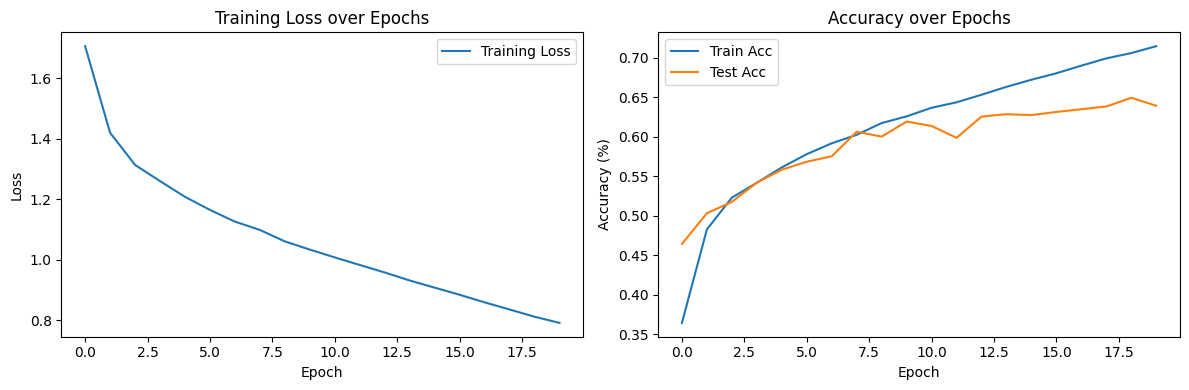

In [19]:
lr = 0.001
batch_size = 64
num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_losses, train_accuracies, test_accuracies = train(optimizer, batch_size, num_epochs)
plot_graphs(train_losses, train_accuracies, test_accuracies)


batch_size = 64 <br>
learning_rate = [0.01, 0.001, 0.0001]

------------- lr=0.01 -------------
Epoch 01: Loss = 2.2112, Train Acc = 0.16, Test Acc = 0.17
Epoch 02: Loss = 2.1556, Train Acc = 0.17, Test Acc = 0.18
Epoch 03: Loss = 2.1748, Train Acc = 0.17, Test Acc = 0.17
Epoch 04: Loss = 2.2208, Train Acc = 0.16, Test Acc = 0.19
Epoch 05: Loss = 2.2395, Train Acc = 0.15, Test Acc = 0.15
Epoch 06: Loss = 2.2076, Train Acc = 0.16, Test Acc = 0.18
Epoch 07: Loss = 2.2078, Train Acc = 0.16, Test Acc = 0.18
Epoch 08: Loss = 2.1833, Train Acc = 0.17, Test Acc = 0.16
Epoch 09: Loss = 2.2082, Train Acc = 0.16, Test Acc = 0.17
Epoch 10: Loss = 2.1959, Train Acc = 0.16, Test Acc = 0.18
Epoch 11: Loss = 2.1893, Train Acc = 0.16, Test Acc = 0.15
Epoch 12: Loss = 2.1892, Train Acc = 0.17, Test Acc = 0.14
Epoch 13: Loss = 2.2289, Train Acc = 0.15, Test Acc = 0.12
Epoch 14: Loss = 2.2090, Train Acc = 0.16, Test Acc = 0.16
Epoch 15: Loss = 2.1739, Train Acc = 0.17, Test Acc = 0.15
Epoch 16: Loss = 2.1516, Train Acc = 0.18, Test Acc = 0.16
Epoch 17: Loss = 2.1

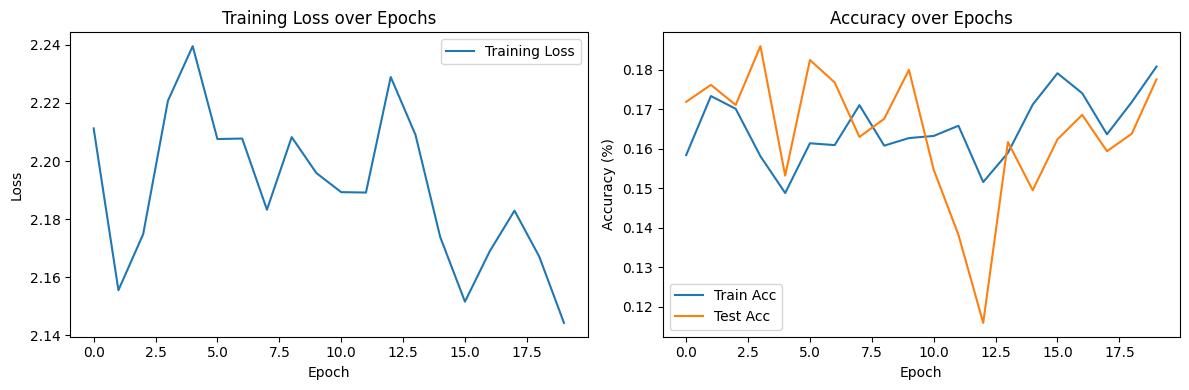

------------- lr=0.001 -------------
Epoch 01: Loss = 1.7281, Train Acc = 0.36, Test Acc = 0.46
Epoch 02: Loss = 1.4306, Train Acc = 0.48, Test Acc = 0.48
Epoch 03: Loss = 1.3345, Train Acc = 0.51, Test Acc = 0.52
Epoch 04: Loss = 1.2667, Train Acc = 0.54, Test Acc = 0.54
Epoch 05: Loss = 1.2216, Train Acc = 0.55, Test Acc = 0.56
Epoch 06: Loss = 1.1785, Train Acc = 0.57, Test Acc = 0.55
Epoch 07: Loss = 1.1439, Train Acc = 0.59, Test Acc = 0.58
Epoch 08: Loss = 1.1159, Train Acc = 0.59, Test Acc = 0.58
Epoch 09: Loss = 1.0795, Train Acc = 0.61, Test Acc = 0.60
Epoch 10: Loss = 1.0535, Train Acc = 0.62, Test Acc = 0.61
Epoch 11: Loss = 1.0269, Train Acc = 0.63, Test Acc = 0.60
Epoch 12: Loss = 0.9975, Train Acc = 0.64, Test Acc = 0.61
Epoch 13: Loss = 0.9735, Train Acc = 0.65, Test Acc = 0.61
Epoch 14: Loss = 0.9522, Train Acc = 0.66, Test Acc = 0.62
Epoch 15: Loss = 0.9230, Train Acc = 0.67, Test Acc = 0.62
Epoch 16: Loss = 0.8975, Train Acc = 0.68, Test Acc = 0.63
Epoch 17: Loss = 0.

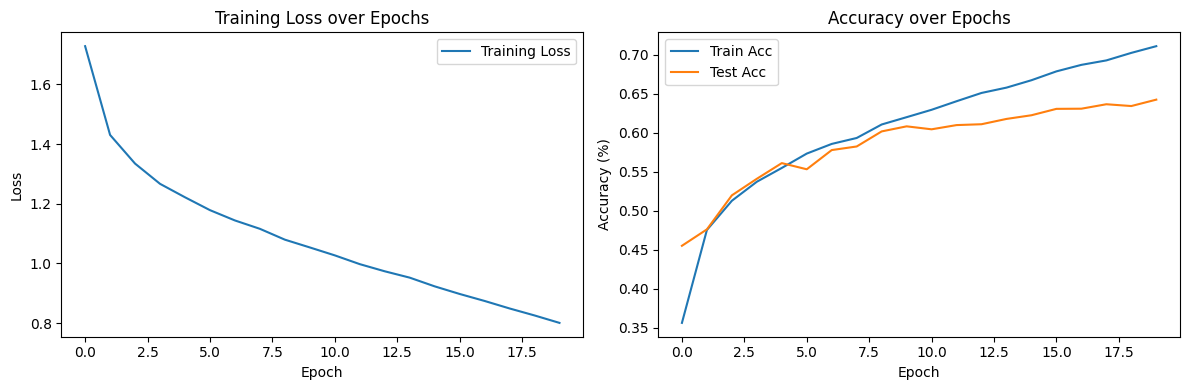

------------- lr=0.0001 -------------
Epoch 01: Loss = 1.7847, Train Acc = 0.34, Test Acc = 0.42
Epoch 02: Loss = 1.4924, Train Acc = 0.46, Test Acc = 0.51
Epoch 03: Loss = 1.3267, Train Acc = 0.52, Test Acc = 0.52
Epoch 04: Loss = 1.2303, Train Acc = 0.55, Test Acc = 0.57
Epoch 05: Loss = 1.1632, Train Acc = 0.58, Test Acc = 0.59
Epoch 06: Loss = 1.1084, Train Acc = 0.60, Test Acc = 0.59
Epoch 07: Loss = 1.0616, Train Acc = 0.62, Test Acc = 0.60
Epoch 08: Loss = 1.0244, Train Acc = 0.63, Test Acc = 0.60
Epoch 09: Loss = 0.9859, Train Acc = 0.64, Test Acc = 0.62
Epoch 10: Loss = 0.9495, Train Acc = 0.66, Test Acc = 0.62
Epoch 11: Loss = 0.9243, Train Acc = 0.67, Test Acc = 0.64
Epoch 12: Loss = 0.8878, Train Acc = 0.68, Test Acc = 0.64
Epoch 13: Loss = 0.8653, Train Acc = 0.69, Test Acc = 0.64
Epoch 14: Loss = 0.8305, Train Acc = 0.70, Test Acc = 0.65
Epoch 15: Loss = 0.8064, Train Acc = 0.71, Test Acc = 0.65
Epoch 16: Loss = 0.7743, Train Acc = 0.72, Test Acc = 0.66
Epoch 17: Loss = 0

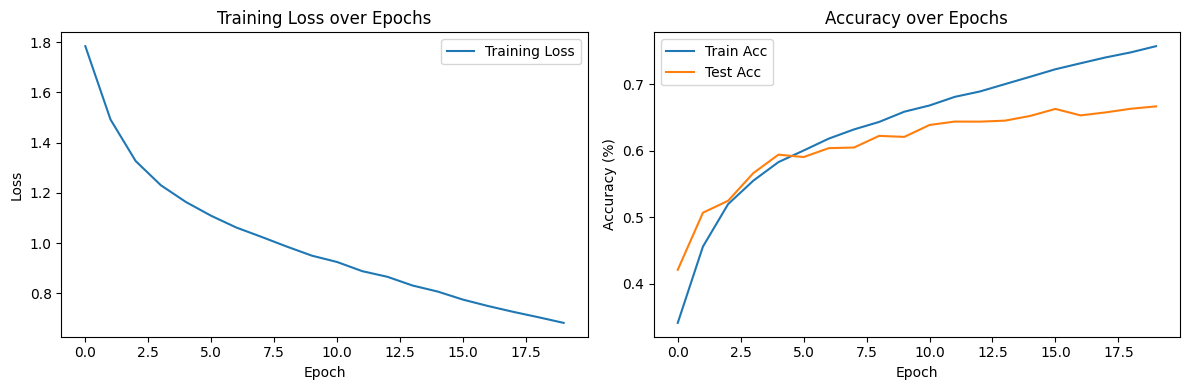

In [18]:
batch_size = 64
num_epochs = 20
lrs = [0.01, 0.001, 0.0001]

for lr in lrs:
    print(f'------------- lr={lr} -------------')
    model = VisionTransformer().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses, train_accuracies, test_accuracies = train(optimizer, batch_size, num_epochs)
    plot_graphs(train_losses, train_accuracies, test_accuracies)


lr = best_lr <br>
optiminzer = RMSProp

Epoch 01: Loss = 1.7728, Train Acc = 0.34, Test Acc = 0.36
Epoch 02: Loss = 1.5299, Train Acc = 0.44, Test Acc = 0.46
Epoch 03: Loss = 1.3802, Train Acc = 0.50, Test Acc = 0.48
Epoch 04: Loss = 1.2711, Train Acc = 0.54, Test Acc = 0.53
Epoch 05: Loss = 1.1930, Train Acc = 0.57, Test Acc = 0.56
Epoch 06: Loss = 1.1330, Train Acc = 0.59, Test Acc = 0.52
Epoch 07: Loss = 1.0836, Train Acc = 0.61, Test Acc = 0.57
Epoch 08: Loss = 1.0437, Train Acc = 0.62, Test Acc = 0.58
Epoch 09: Loss = 1.0070, Train Acc = 0.64, Test Acc = 0.60
Epoch 10: Loss = 0.9753, Train Acc = 0.65, Test Acc = 0.58
Epoch 11: Loss = 0.9438, Train Acc = 0.66, Test Acc = 0.60
Epoch 12: Loss = 0.9158, Train Acc = 0.67, Test Acc = 0.62
Epoch 13: Loss = 0.8876, Train Acc = 0.68, Test Acc = 0.64
Epoch 14: Loss = 0.8593, Train Acc = 0.69, Test Acc = 0.64
Epoch 15: Loss = 0.8329, Train Acc = 0.70, Test Acc = 0.64
Epoch 16: Loss = 0.8085, Train Acc = 0.71, Test Acc = 0.64
Epoch 17: Loss = 0.7839, Train Acc = 0.72, Test Acc = 0.

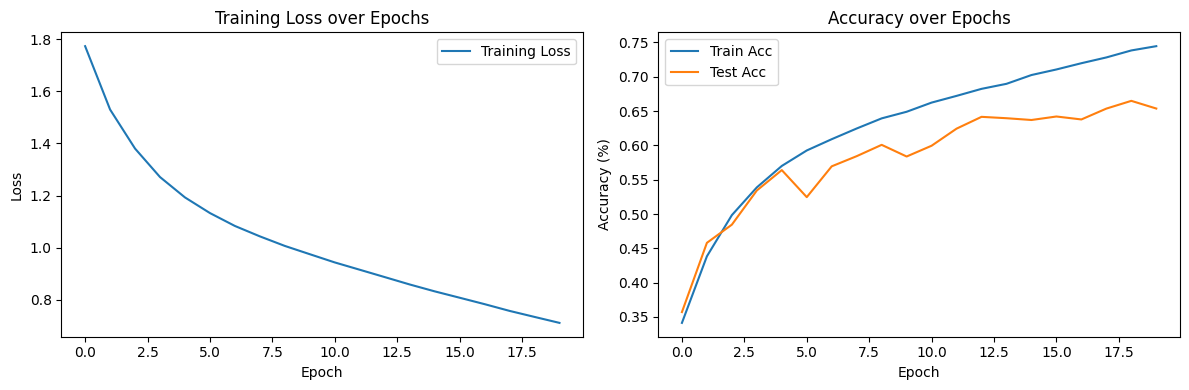

In [24]:
batch_size = 64
num_epochs = 20
best_lr = 0.0001 # best_lr

model = VisionTransformer().to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=best_lr)
train_losses, train_accuracies, test_accuracies = train(optimizer, batch_size, num_epochs)
plot_graphs(train_losses, train_accuracies, test_accuracies)

num_layers = 4

Epoch 01: Loss = 1.7711, Train Acc = 0.34, Test Acc = 0.43
Epoch 02: Loss = 1.4993, Train Acc = 0.45, Test Acc = 0.49
Epoch 03: Loss = 1.3536, Train Acc = 0.51, Test Acc = 0.53
Epoch 04: Loss = 1.2527, Train Acc = 0.54, Test Acc = 0.56
Epoch 05: Loss = 1.1829, Train Acc = 0.57, Test Acc = 0.58
Epoch 06: Loss = 1.1261, Train Acc = 0.59, Test Acc = 0.58
Epoch 07: Loss = 1.0719, Train Acc = 0.61, Test Acc = 0.60
Epoch 08: Loss = 1.0286, Train Acc = 0.63, Test Acc = 0.60
Epoch 09: Loss = 0.9918, Train Acc = 0.64, Test Acc = 0.62
Epoch 10: Loss = 0.9556, Train Acc = 0.66, Test Acc = 0.64
Epoch 11: Loss = 0.9212, Train Acc = 0.67, Test Acc = 0.63
Epoch 12: Loss = 0.8946, Train Acc = 0.68, Test Acc = 0.65
Epoch 13: Loss = 0.8662, Train Acc = 0.69, Test Acc = 0.65
Epoch 14: Loss = 0.8365, Train Acc = 0.70, Test Acc = 0.64
Epoch 15: Loss = 0.8112, Train Acc = 0.71, Test Acc = 0.66
Epoch 16: Loss = 0.7885, Train Acc = 0.72, Test Acc = 0.65
Epoch 17: Loss = 0.7610, Train Acc = 0.73, Test Acc = 0.

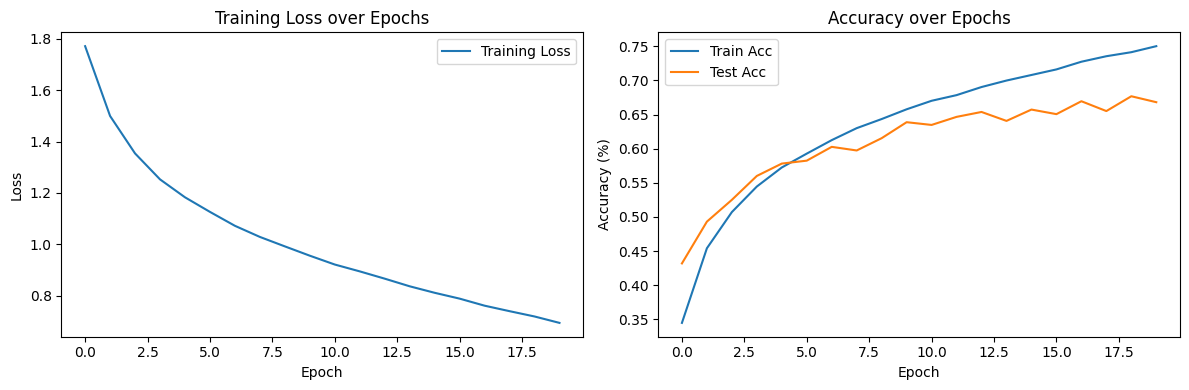

In [25]:
model = VisionTransformer(num_layers=4).to(device)
lr = best_lr
batch_size = 64
num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_losses, train_accuracies, test_accuracies = train(optimizer, batch_size, num_epochs)
plot_graphs(train_losses, train_accuracies, test_accuracies)

num_layers = 8

Epoch 01: Loss = 1.7953, Train Acc = 0.33, Test Acc = 0.41
Epoch 02: Loss = 1.5066, Train Acc = 0.45, Test Acc = 0.49
Epoch 03: Loss = 1.3313, Train Acc = 0.51, Test Acc = 0.54
Epoch 04: Loss = 1.2327, Train Acc = 0.55, Test Acc = 0.56
Epoch 05: Loss = 1.1605, Train Acc = 0.58, Test Acc = 0.56
Epoch 06: Loss = 1.1031, Train Acc = 0.60, Test Acc = 0.61
Epoch 07: Loss = 1.0544, Train Acc = 0.62, Test Acc = 0.62
Epoch 08: Loss = 1.0105, Train Acc = 0.64, Test Acc = 0.62
Epoch 09: Loss = 0.9771, Train Acc = 0.65, Test Acc = 0.63
Epoch 10: Loss = 0.9374, Train Acc = 0.66, Test Acc = 0.63
Epoch 11: Loss = 0.9056, Train Acc = 0.68, Test Acc = 0.66
Epoch 12: Loss = 0.8716, Train Acc = 0.69, Test Acc = 0.65
Epoch 13: Loss = 0.8456, Train Acc = 0.70, Test Acc = 0.66
Epoch 14: Loss = 0.8170, Train Acc = 0.70, Test Acc = 0.66
Epoch 15: Loss = 0.7862, Train Acc = 0.72, Test Acc = 0.67
Epoch 16: Loss = 0.7618, Train Acc = 0.73, Test Acc = 0.66
Epoch 17: Loss = 0.7364, Train Acc = 0.74, Test Acc = 0.

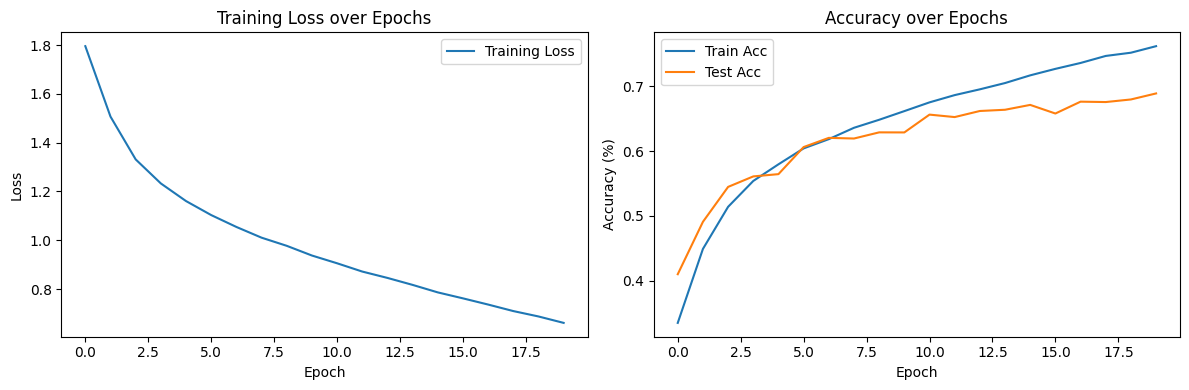

In [26]:
model = VisionTransformer(num_layers=8).to(device)
lr = best_lr
batch_size = 64
num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_losses, train_accuracies, test_accuracies = train(optimizer, batch_size, num_epochs)
plot_graphs(train_losses, train_accuracies, test_accuracies)